In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import matplotlib.pyplot as plt
import torch, torch.nn as nn
import norse
import sys
print(torch.cuda.is_available())

import norse.torch as norse

True


Dataset creation

In [2]:
x = 41
y = 41
dt = 0.001

def set_params(x,y,dt):
    nb_timesteps = int((x - 1)/2)
    nb_repetitions = int(1/(dt*nb_timesteps))
    return nb_timesteps, nb_repetitions

nb_timesteps, nb_repetitions = set_params(x,y,dt)
print(nb_timesteps)
print(nb_repetitions)

x_p = 3
y_p = 3
point = np.ones((x_p,y_p))

20
50


In [3]:
mvt_right = np.zeros((nb_timesteps+1,x,y))
mvt_left = np.zeros((nb_timesteps+1,x,y))
mvt_up = np.zeros((nb_timesteps+1,x,y))
mvt_down = np.zeros((nb_timesteps+1,x,y))

for i in range(nb_timesteps):
    mvt_down[i+1,x//2-1+i:x//2+2+i,y//2-1:y//2+2]+=point
    mvt_down[i]=abs(mvt_down[i+1]-mvt_down[i])
    mvt_up[i+1,x//2-1-i:x//2+2-i,y//2-1:y//2+2]+=point
    mvt_up[i]=abs(mvt_up[i+1]-mvt_up[i])
    mvt_right[i+1,x//2-1:x//2+2,y//2-1+i:y//2+2+i]+=point
    mvt_right[i]=abs(mvt_right[i+1]-mvt_right[i])
    mvt_left[i+1,x//2-1:x//2+2,y//2-1-i:y//2+2-i]+=point
    mvt_left[i]=abs(mvt_left[i+1]-mvt_left[i])

mvt_down = mvt_down[:nb_timesteps]
mvt_up = mvt_up[:nb_timesteps]
mvt_left = mvt_left[:nb_timesteps]
mvt_right = mvt_right[:nb_timesteps]

#fig, axs = plt.subplots(nb_timesteps,figsize=(100,100))
#for i in range(nb_timesteps):
#    axs[i].imshow(mvt_up[i])

Creation of the architecture

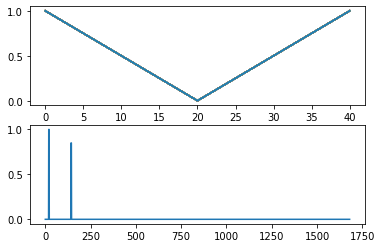

In [4]:
from norse.torch.module import izhikevich as izk
from norse.torch.functional.izhikevich import *
weights_ini_up = np.zeros((x,y))
weights_ini_down = np.zeros((x,y))
for i in range(x):
    if i <= (x-1)/2 :
        weights_ini_up[i,:]+=(1-(2*i/(x-1)))
    if i >= (x-1)/2 :
        weights_ini_down[i,:]+=(1-(2*(x-i-1)/(x-1)))
        
input_matrix = torch.tensor(mvt_up[-1]*weights_ini_up)
#SC = izk.IzhikevichCell(phasic_spiking, dt=dt)
#z_1, s_1 = SC(input_matrix)
#z_1 = np.reshape(z_1.detach().numpy(),(x*y,))
z_1 = np.reshape(input_matrix.numpy(),(x*y,))
fig, axs = plt.subplots(2)
axs[0].plot(weights_ini_up + weights_ini_down)
axs[1].plot(z_1)

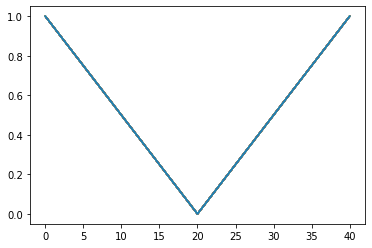

In [5]:
plt.plot(weights_ini_up + weights_ini_down)

/home/adridelp/testPyTorch/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/adridelp/testPyTorch/lib/python3.8/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, su

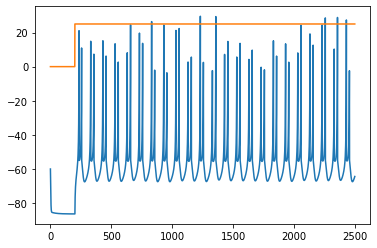

In [134]:
LLBN_behaviour = createIzhikevichSpikingBehaviour(
    0.1,-0.075,-55,6,-60,-60,tau_inv=250,current=25,print=True)

In [7]:
LLBN = izk.IzhikevichRecurrentCell(x*y+1,1,LLBN_behaviour,autapses=True,dt=dt)

#z_2, s_2 = LLBN((z_1 - temp).float())
#plt.imshow(z_2.detach().numpy())

In [135]:
EBN = izk.IzhikevichCell(x*y+1,1,phasic_bursting,dt=dt)
#z_in = z_1 + z_2
#z_3, s_3 = EBN(z_in)

TypeError: __init__() takes 2 positional arguments but 4 were given

In [9]:
IFN = izk.IzhikevichCell(phasic_spiking,dt=dt)
#z_4, s_4 = IFN(z_3)
#temp = z_4

In [91]:
TN = izk.IzhikevichRecurrentCell(x*y+1,1,tonic_bursting,autapses=True,dt=dt)
#z_5, s_5 = TN(z_4.float())
#print(z_5.detach().numpy())

In [11]:
MN = izk.IzhikevichCell(phasic_spiking,dt=dt)

In [12]:
from time import perf_counter

In [127]:
def forward(input_mat, weights_ini, nb_timesteps, nb_repetitions):
    tm_small = 0
    tm_big = 0
    tm_tot_start = perf_counter()
    temp = torch.zeros((x*y,))
    print_v2 = np.zeros(0)
    print_v3 = np.zeros(0)
    print_v4 = np.zeros(0)
    print_v5 = np.zeros(0)
    print_v6 = np.zeros(0)
    fig, axs = plt.subplots(5,figsize=(30,30))
    for i in range(nb_timesteps):
        tm1_start = perf_counter() 
        input_matrix = input_mat[i]*weights_ini
        z_1 = torch.tensor(np.reshape(input_matrix,(x*y,)))
        for j in range(nb_repetitions):
            if i == 0:
                tm2_start = perf_counter() 
                z_2, s_2 = LLBN(torch.tensor(np.append(z_1.detach().numpy(),-temp.detach().numpy()[0])).float())
                print_v2 = np.append(print_v2,s_2.v.detach().numpy())
                z_in = torch.tensor(np.append(z_1.detach().numpy(),z_2.detach().numpy()))
                z_3, s_3 = EBN(w*z_in)
                print_v3 = np.append(print_v3,s_3.v.detach().numpy())
                z_4, s_4 = IFN(w*z_3)
                print_v4 = np.append(print_v4,s_4.v.detach().numpy())
                temp = z_4
                z_5, s_5 = TN(w*z_3.float())
                print_v5 = np.append(print_v5,s_5.v.detach().numpy())
                z_6, s_6 = MN(w*z_5)
                print_v6 = np.append(print_v6,s_6.v.detach().numpy())
                tm2_stop = perf_counter()
                tm_small += tm2_stop-tm2_start
            else:
                tm2_start = perf_counter()
                z_2, s_2 = LLBN(torch.tensor(np.append(z_1.detach().numpy(),-temp.detach().numpy()[0])).float(), s_2)
                print_v2 = np.append(print_v2,s_2.v.detach().numpy())
                z_in = torch.tensor(np.append(z_1.detach().numpy(),z_2.detach().numpy()))
                z_3, s_3 = EBN(w*z_in, s_3)
                print_v3 = np.append(print_v3,s_3.v.detach().numpy())
                z_4, s_4 = IFN(w*z_3, s_4)
                print_v4 = np.append(print_v4,s_4.v.detach().numpy())
                temp = z_4
                z_5, s_5 = TN(w*z_3.float(), s_5)
                print_v5 = np.append(print_v5,s_5.v.detach().numpy())
                z_6, s_6 = MN(w*z_5, s_5)
                print_v6 = np.append(print_v6,s_6.v.detach().numpy())
                tm2_stop = perf_counter()
                tm_small += tm2_stop-tm2_start
        tm1_stop = perf_counter()
        tm_big += tm1_stop-tm1_start
    tm_tot_stop = perf_counter()
    print(tm_small/(nb_timesteps*nb_repetitions))
    print(tm_big/nb_timesteps)
    print(tm_tot_stop - tm_tot_start)
    axs[0].plot(print_v2)
    axs[1].plot(print_v3)
    axs[2].plot(print_v4)
    axs[3].plot(print_v5)
    axs[4].plot(print_v6)

0.0030477296605240555
0.15251027450431137
3.1127536620479077


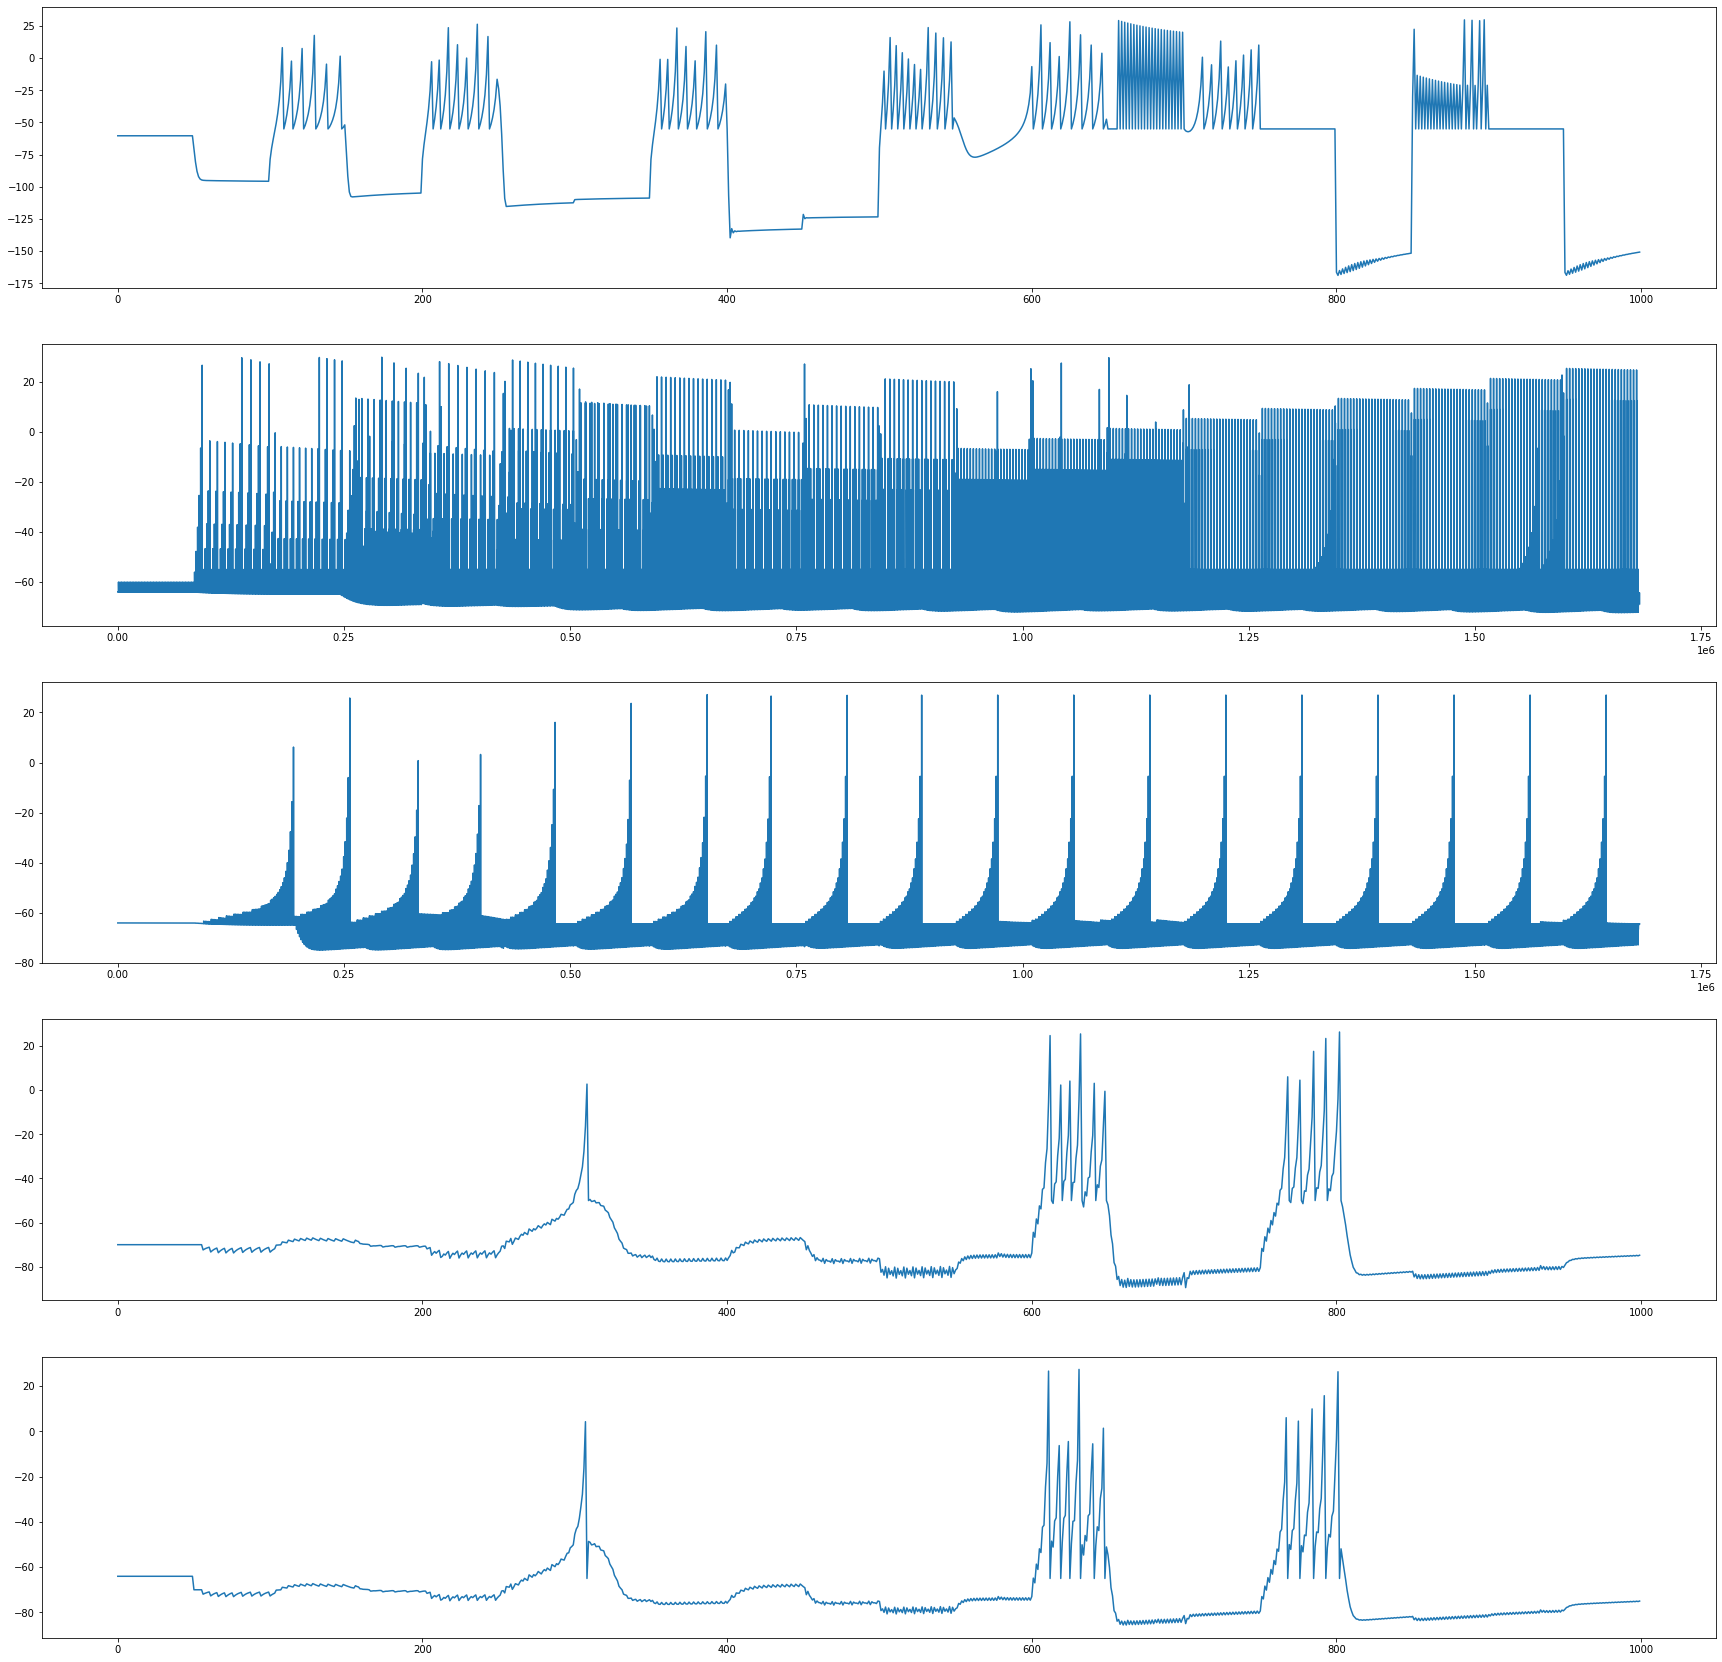

In [128]:
with torch.no_grad():
    forward(mvt_up, weights_ini_up*100, nb_timesteps,nb_repetitions)

In [15]:
temp1 = torch.zeros((5,))
temp2 = torch.ones((5,))
print(temp1+temp2)

tensor([1., 1., 1., 1., 1.])


In [94]:
def forward_test(input_mat, weights_matrix, nb_timesteps, nb_repetitions):
    tm_small = 0
    tm_big = 0
    tm_tot_start = perf_counter()
    temp = torch.zeros((x*y,))
    print_v2 = np.zeros(0)
    print_v3 = np.zeros(0)
    print_v4 = np.zeros(0)
    print_v5 = np.zeros(0)
    print_v6 = np.zeros(0)
    fig, axs = plt.subplots(5,figsize=(30,30))
    LLBN = izk.IzhikevichRecurrentCell(x*y,x*y,LLBN_behaviour,autapses=True,dt=dt)
    TN = izk.IzhikevichRecurrentCell(x*y,x*y,tonic_spiking,autapses=True,dt=dt)
    for i in range(nb_timesteps):
        tm1_start = perf_counter() 
        input_matrix = input_mat[i]*weights_matrix[0]
        z_1 = torch.tensor(np.reshape(input_matrix,(x*y,)))
        for j in range(nb_repetitions):
            if i == 0:
                tm2_start = perf_counter()
                z_2, s_2 = LLBN((z_1*weights_matrix[1] - temp).float())
                print_v2 = np.append(print_v2,s_2.v.detach().numpy())
                z_in = z_1*weights_matrix[2] + z_2*weights_matrix[3]
                z_3, s_3 = EBN(z_in)
                print_v3 = np.append(print_v3,s_3.v.detach().numpy())
                z_4, s_4 = IFN(z_3*weights_matrix[4])
                print_v4 = np.append(print_v4,s_4.v.detach().numpy())
                temp = z_4*weights_matrix[5]
                z_5, s_5 = TN(z_3.float()*weights_matrix[6])
                print_v5 = np.append(print_v5,s_5.v.detach().numpy())
                z_6, s_6 = MN(z_5*weights_matrix[7])
                print_v6 = np.append(print_v6,s_6.v.detach().numpy())
                tm2_stop = perf_counter()
                tm_small += tm2_stop-tm2_start
            else:
                tm2_start = perf_counter()
                z_2, s_2 = LLBN((z_1*weights_matrix[1] - temp).float(), s_2)
                print_v2 = np.append(print_v2,s_2.v.detach().numpy())
                z_in = z_1*weights_matrix[2] + z_2*weights_matrix[3]
                z_3, s_3 = EBN(z_in, s_3)
                print_v3 = np.append(print_v3,s_3.v.detach().numpy())
                z_4, s_4 = IFN(z_3*weights_matrix[4], s_4)
                print_v4 = np.append(print_v4,s_4.v.detach().numpy())
                temp = z_4*weights_matrix[5]
                z_5, s_5 = TN(z_3.float()*weights_matrix[6], s_5)
                print_v5 = np.append(print_v5,s_5.v.detach().numpy())
                z_6, s_6 = MN(z_5*weights_matrix[7], s_5)
                print_v6 = np.append(print_v6,s_6.v.detach().numpy())
                tm2_stop = perf_counter()
                tm_small += tm2_stop-tm2_start
        tm1_stop = perf_counter()
        tm_big += tm1_stop-tm1_start
    tm_tot_stop = perf_counter()
    print(tm_small/(nb_timesteps*nb_repetitions))
    print(tm_big/nb_timesteps)
    print(tm_tot_stop - tm_tot_start)
    axs[0].plot(print_v2)
    axs[1].plot(print_v3)
    axs[2].plot(print_v4)
    axs[3].plot(print_v5)
    axs[4].plot(print_v6)

0.008033106200397015
0.40181601693620905
8.197257763938978


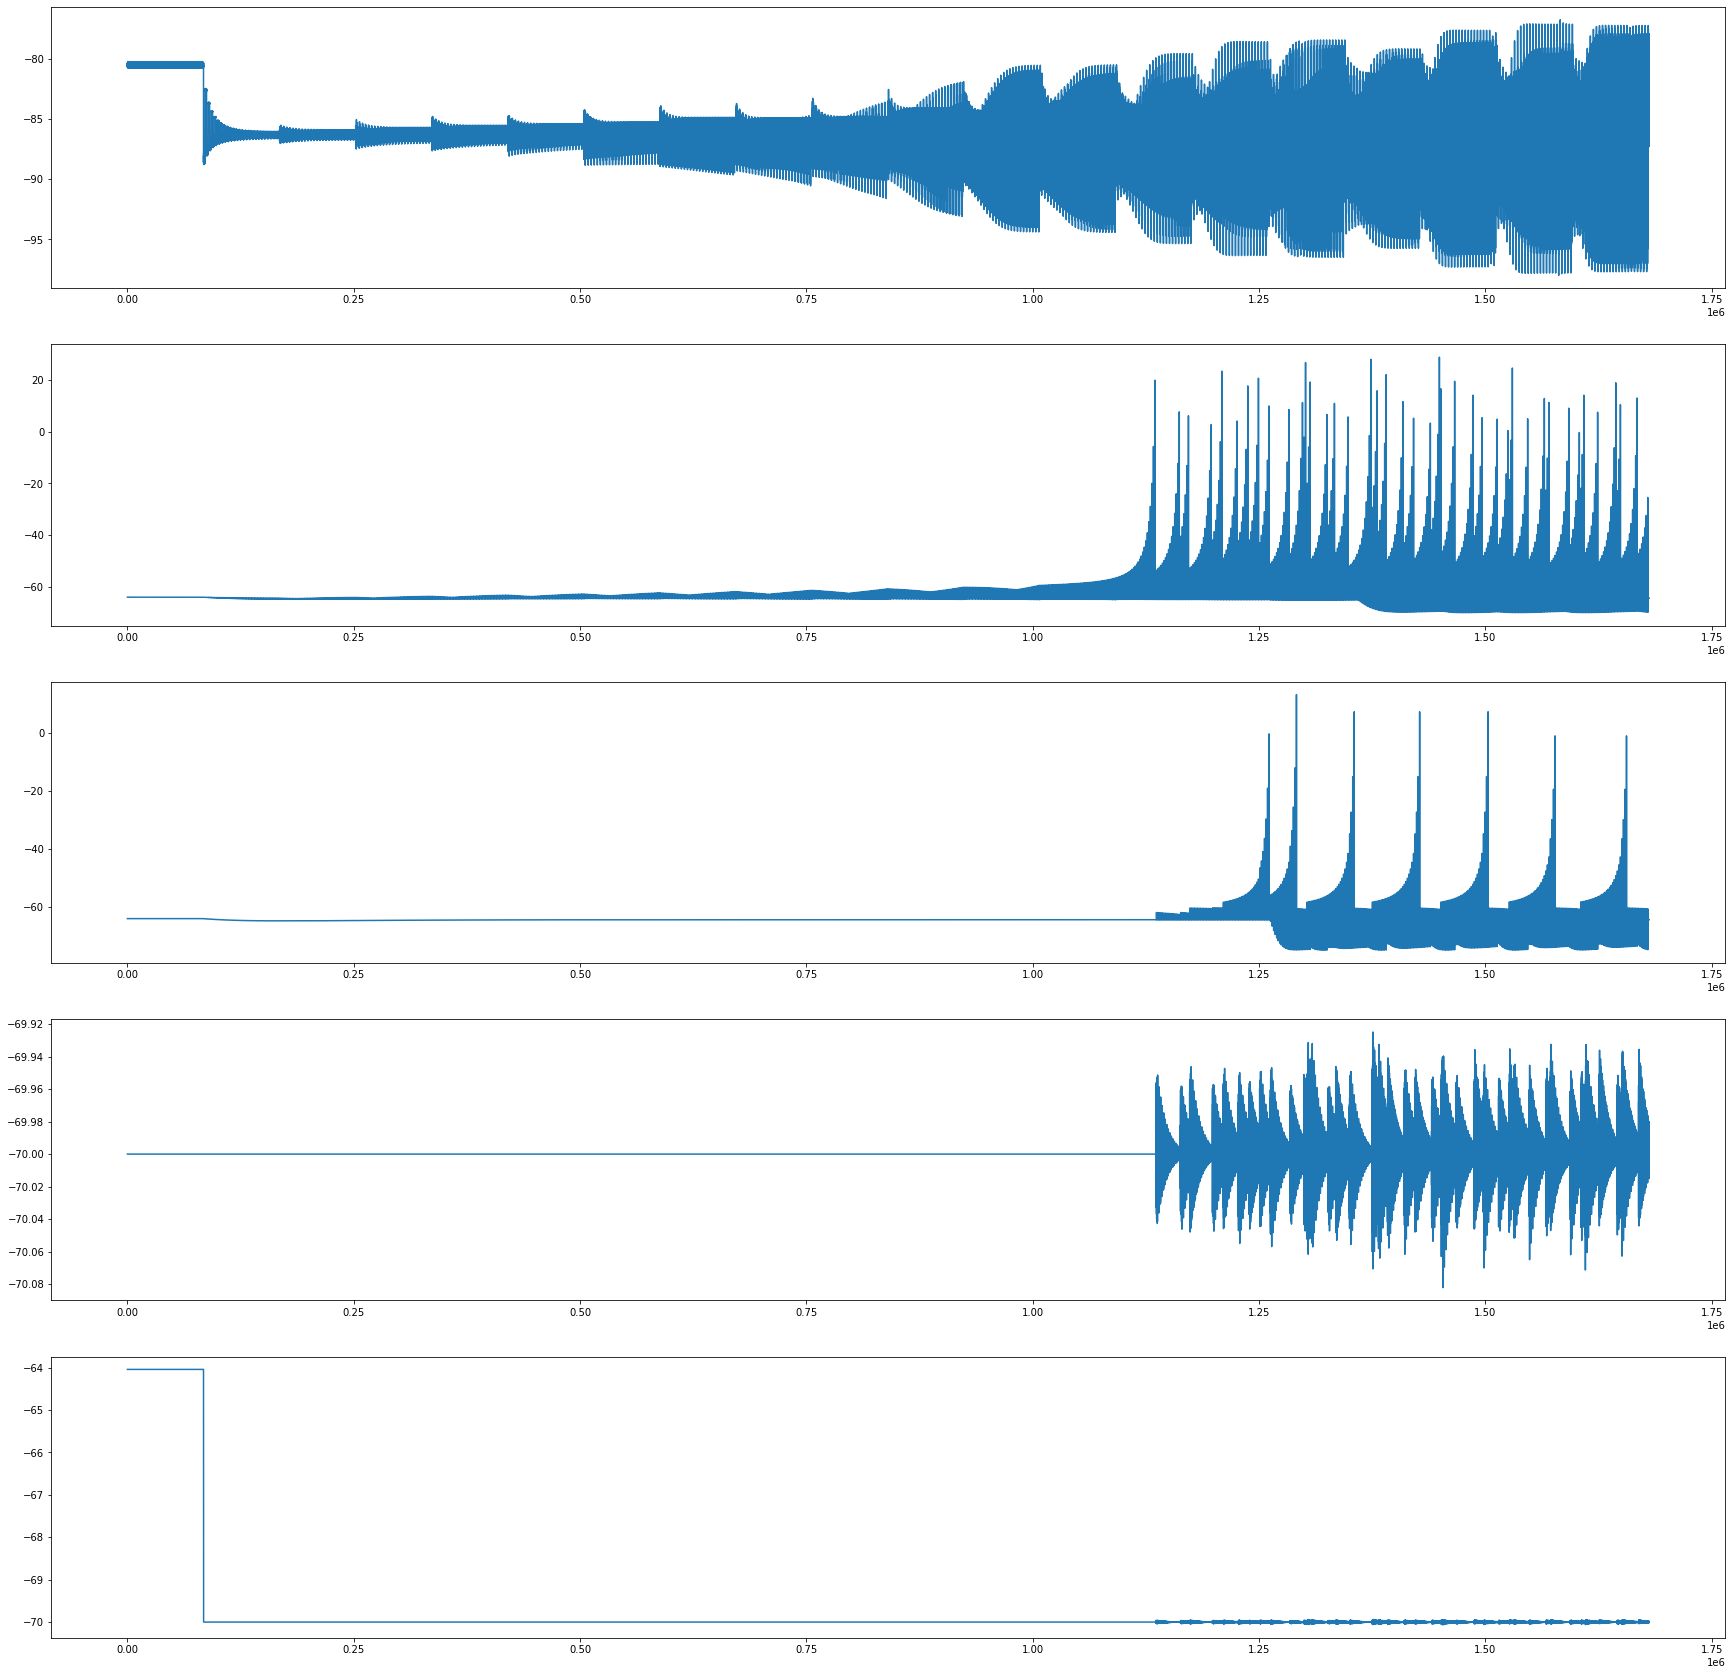

In [133]:
weight_to_LLBN = 25
weight_to_EBN = 1
weight_LLBN_EBN = 1
weight_EBN_IFN = 10
weight_IFN_LLBN = 2.5
weight_EBN_TN = 1
weight_TN_MN = 1
weight_matrix = [weights_ini_up, weight_to_LLBN, weight_to_EBN, weight_LLBN_EBN, 
                 weight_EBN_IFN, weight_IFN_LLBN, weight_EBN_TN ,weight_TN_MN]

forward_test(mvt_up, weight_matrix, nb_timesteps,nb_repetitions)